In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import utils
from whitelists import *
from sorted_crates import *
from top_crates import *
import functools

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

In [2]:
# Load tables
function_definitions = utils.load_selected_function_definitions()
raw_function_unsafe_reasons = utils.load_unsafe_reasons_in_function_definitions()
unsafe_block_calls = utils.load_unsafe_block_calls()
const_calls = utils.load_const_calls()
unsafe_blocks = utils.load_unsafe_blocks()
traits = utils.load_selected_traits()
traits_impls = utils.load_selected_impl_definitions()
type_defs = utils.load_selected_type_defs()
adts = utils.load_selected_adts()
adt_field_types = utils.load_selected_adt_field_types()
selected_builds = utils.load_selected_builds()

In [3]:
# Cleanup: remove duplicates
raw_function_unsafe_reasons = raw_function_unsafe_reasons.drop_duplicates()

# Remove functions that are not in function_definitions
raw_function_unsafe_reasons = raw_function_unsafe_reasons[
    raw_function_unsafe_reasons.def_path.isin(set(function_definitions.def_path.unique()))
]

possible_unsafe_reasons = [
    "call to unsafe function",
    "use of inline assembly",
    "initializing type with `rustc_layout_scalar_valid_range` attr",
    "cast of pointer to int",
    "pointer operation",
    "borrow of packed field",
    "use of mutable static",
    "use of extern static",
    "dereference of raw pointer",
    "assignment to non-`Copy` union field",
    "access to union field",
    "mutation of layout constrained field",
    "borrow of layout constrained field with interior mutability",
]

# Map reasons -> number
function_unsafe_reasons = raw_function_unsafe_reasons[
    ["crate_name", "crate_hash", "def_path", "unsafe_reason"]
].groupby("def_path").agg(frozenset).rename(
    columns={'unsafe_reason': 'unsafe_reasons'}
)

function_unsafe_reasons["unsafe_reasons_vec"] = function_unsafe_reasons.unsafe_reasons.map(
    lambda x: [reason in x for reason in possible_unsafe_reasons]
)
function_unsafe_reasons["num_unsafe_reasons"] = function_unsafe_reasons.unsafe_reasons_vec.map(sum)

for reason in possible_unsafe_reasons:
    function_unsafe_reasons[reason] = function_unsafe_reasons.unsafe_reasons.map(
        lambda x: reason in x
    )

# Augment const calls made from unsafe blocks
unsafe_block_const_calls = unsafe_block_calls.join(
    const_calls.set_index("call"),
    on="call",
    how="inner",
    rsuffix="_defsite",
)
# Rename confusing columns
unsafe_block_const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)
const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)

# Preprocessing
crates = pd.DataFrame({
    "crate": selected_builds.crate,
    "crate_hash": selected_builds.crate_hash,
    "package": selected_builds.package.map(lambda x: str(x).lower().replace("-", "_")),
})
user_written_unsafe_blocks = unsafe_blocks[unsafe_blocks.check_mode == "UnsafeBlockUserProvided"]
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]
unsafe_traits = traits[traits.unsafety == "Unsafe"]
unsafe_traits_impls = traits_impls[traits_impls.unsafety == "Unsafe"]

In [4]:
# Whitelists
all_function_names = set(function_definitions.def_path.unique())
unchecked_function_names = get_unchecked_function_names(all_function_names)
unguarded_function_names = get_unguarded_function_names(all_function_names)

In [5]:
# Calls
all_calls = utils.load_all_calls()
unsafe_calls = all_calls.query("unsafety != 'Normal'")
assert len(pd.unique(unsafe_calls.unsafety)) == 1

In [6]:
### Filter by user-written unsafe code
user_written_unsafe_const_calls = const_calls[
    const_calls.check_mode == "UnsafeBlockUserProvided"
]

slice_call = []
for x in user_written_unsafe_const_calls.def_path.unique():
    if x.endswith('::slice[0]::from_raw_parts[0]'):
        slice_call.append(x)
        break

parts = slice_call[0].split("[")
core_hash = parts[1].split("]")[0]
core_hash

'7bab'

In [7]:
# Top X Crates
def norm(x):
    return x.lower().replace("-", "_")

top_250_compiling_crates = set(map(norm, sorted_crates[:250])) & set(map(norm, selected_builds.package.unique()))
top_250_crates_set = set(sorted_crates[:250])
top_250_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_250_crates_set)
top_250_builds = selected_builds[top_250_mask][
    ~selected_builds[top_250_mask]["package"].duplicated()
]
top_500_compiling_crates = set(map(norm, sorted_crates[:500])) & set(map(norm, selected_builds.package.unique()))
top_500_crates_set = set(sorted_crates[:500])
top_500_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_500_crates_set)
top_500_builds = selected_builds[top_500_mask][
    ~selected_builds[top_500_mask]["package"].duplicated()
]
top_1000_compiling_crates = set(map(norm, sorted_crates[:1000])) & set(map(norm, selected_builds.package.unique()))
top_1000_crates_set = set(sorted_crates[:1000])
top_1000_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_1000_crates_set)
top_1000_builds = selected_builds[top_1000_mask][
    ~selected_builds[top_1000_mask]["package"].duplicated()
]

In [8]:
print("Number of compiling crates in top 250:\t", len(top_250_compiling_crates))
print("Number of builds in top 250:\t\t", len(top_250_builds))
print("Number of expected crates in top 250:\t", len(sorted_crates[:250]))

Number of compiling crates in top 250:	 248
Number of builds in top 250:		 248
Number of expected crates in top 250:	 250


In [9]:
print("Number of compiling crates in top 500:\t", len(top_500_compiling_crates))
print("Number of builds in top 500:\t\t", len(top_500_builds))
print("Number of expected crates in top 500:\t", len(sorted_crates[:500]))

Number of compiling crates in top 500:	 480
Number of builds in top 500:		 480
Number of expected crates in top 500:	 500


In [10]:
print("Number of compiling crates in top 1000:\t", len(top_1000_compiling_crates))
print("Number of builds in top 1000:\t\t", len(top_1000_builds))
print("Number of expected crates in top 1000:\t", len(sorted_crates[:1000]))

Number of compiling crates in top 1000:	 488
Number of builds in top 1000:		 488
Number of expected crates in top 1000:	 1000


In [11]:
print("Number of selected builds:\t", len(selected_builds))
print("Number of crates total:\t\t", len(crates))

Number of selected builds:	 510
Number of crates total:		 510


------top 250------
ForeignItem    1897
Rust           1271
C                47
Name: abi, dtype: int64

Percents:
ForeignItem    59.004666
Rust           39.533437
C               1.461897
Name: abi, dtype: float64

Unsafe function definitions: 3215


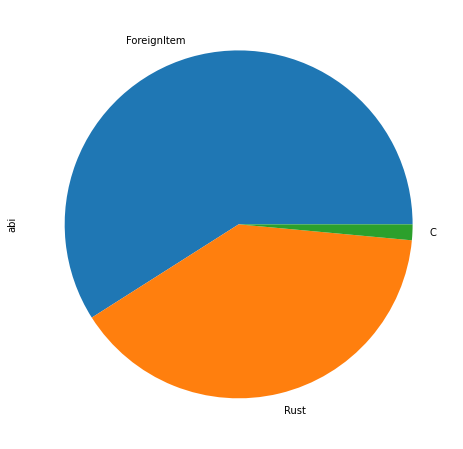

In [12]:
# Frequency of abi DEFINITIONS
top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(sorted_crates[:250])
]
values = top_unsafe_defs.abi.value_counts()

print("------top 250------")
print(values)
print()
print("Percents:")
print(values / len(top_unsafe_defs) * 100)
print()
print("Unsafe function definitions:", len(top_unsafe_defs))
values.plot.pie()

del values, top_unsafe_defs

------top 500------
ForeignItem    3469
Rust           2698
C               176
Name: abi, dtype: int64

Percents:
ForeignItem    54.690210
Rust           42.535078
C               2.774712
Name: abi, dtype: float64

Unsafe function definitions: 6343


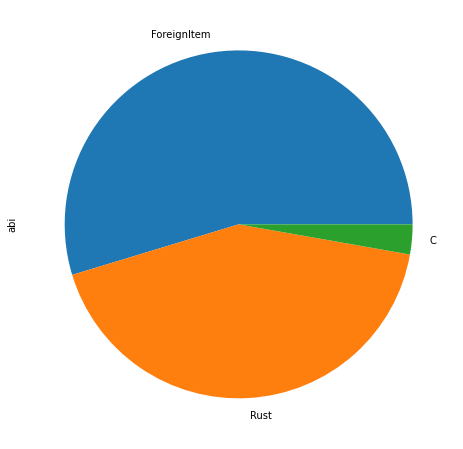

In [13]:
# Frequency of abi DEFINITIONS
top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(sorted_crates[:500])
]
values = top_unsafe_defs.abi.value_counts()

print("------top 500------")
print(values)
print()
print("Percents:")
print(values / len(top_unsafe_defs) * 100)
print()
print("Unsafe function definitions:", len(top_unsafe_defs))
values.plot.pie()

del values, top_unsafe_defs

------top 1000------
ForeignItem    3469
Rust           2699
C               176
Name: abi, dtype: int64

Percents:
ForeignItem    54.681589
Rust           42.544136
C               2.774275
Name: abi, dtype: float64

Unsafe function definitions: 6344


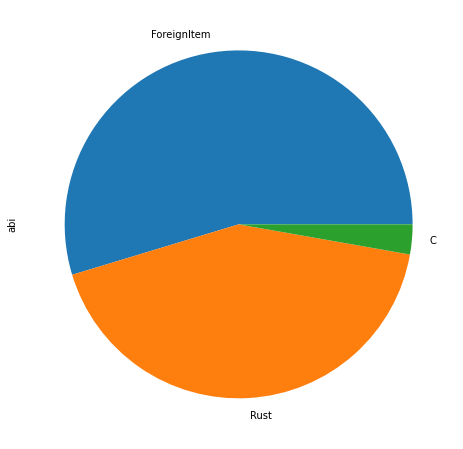

In [14]:
# Frequency of abi DEFINITIONS
top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(sorted_crates[:1000])
]
values = top_unsafe_defs.abi.value_counts()

print("------top 1000------")
print(values)
print()
print("Percents:")
print(values / len(top_unsafe_defs) * 100)
print()
print("Unsafe function definitions:", len(top_unsafe_defs))
values.plot.pie()

del values, top_unsafe_defs

------total------
ForeignItem    3478
Rust           2699
C               176
Name: abi, dtype: int64

Percents:
ForeignItem    54.745789
Rust           42.483866
C               2.770345
Name: abi, dtype: float64

Unsafe function definitions: 6353


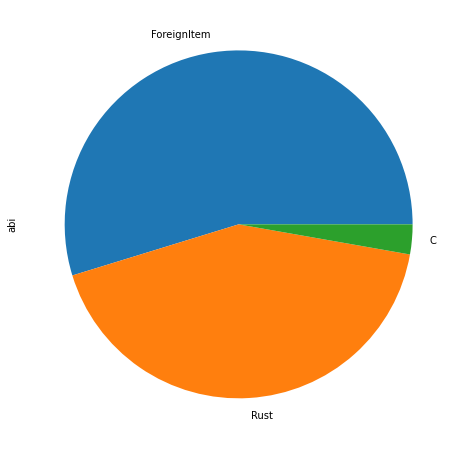

In [15]:
# Frequency of abi DEFINITIONS

values = unsafe_function_definitions.abi.value_counts()

print("------total------")
print(values)
print()
print("Percents:")
print(values / len(unsafe_function_definitions) * 100)
print()
print("Unsafe function definitions:", len(unsafe_function_definitions))
values.plot.pie()

del values

In [16]:
# Which crates define unsafe Rust functions?
def_unsafe_rust_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "Rust"
]

print("------top 250------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(sorted_crates[:250])
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------top 500------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(sorted_crates[:500])
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------top 1000------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(sorted_crates[:1000])
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------total------")
values = def_unsafe_rust_funcs.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values

------top 250------
Number of crates that define unsafe Rust functions:	 92
Top 20 crates with most defined unsafe Rust functions:

futures_util        121
tokio                84
openssl              80
nix                  79
cloudabi             66
core_foundation      58
wasi                 45
openssl_sys          42
aho_corasick         41
hashbrown            34
bytes                33
rayon_core           33
crossbeam_epoch      28
parking_lot          27
memchr               26
hyper                25
ppv_lite86           25
lock_api             23
parking_lot_core     21
encoding_rs          20
Name: crate, dtype: int64
------top 500------
Number of crates that define unsafe Rust functions:	 145
Top 20 crates with most defined unsafe Rust functions:

js_sys             803
futures_util       121
git2               108
tokio               84
openssl             80
nix                 79
blake2b_simd        77
wasm_bindgen        70
cloudabi            66
core_foundation     58

In [17]:
# Which crates define C functions?
def_c_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "C"
]
values = def_c_funcs.crate.value_counts()

print("------top 250------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(sorted_crates[:250])
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Top 20 crates with most defined C functions:")
print()
print(vals[:20])
print()
del vals, def_c

print("------top 500------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(sorted_crates[:500])
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Top 20 crates with most defined C functions:")
print()
print(vals[:20])
print()
del vals, def_c

print("------top 1000------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(sorted_crates[:1000])
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Top 20 crates with most defined C functions:")
print()
print(vals[:20])
print()
del vals, def_c

print("------total------")
print("Number of crates that define C functions:\t", len(values))
print("Top 20 crates with most defined C functions:")
print()
print(values[:20])
del values

------top 250------
Number of crates that define C functions:	 4
Top 20 crates with most defined C functions:

libc         27
openssl      18
backtrace     1
ring          1
Name: crate, dtype: int64

------top 500------
Number of crates that define C functions:	 7
Top 20 crates with most defined C functions:

wasm_bindgen          96
miniz_oxide_c_api     31
libc                  27
openssl               18
security_framework     2
ring                   1
backtrace              1
Name: crate, dtype: int64

------top 1000------
Number of crates that define C functions:	 7
Top 20 crates with most defined C functions:

wasm_bindgen          96
miniz_oxide_c_api     31
libc                  27
openssl               18
security_framework     2
ring                   1
backtrace              1
Name: crate, dtype: int64

------total------
Number of crates that define C functions:	 7
Top 20 crates with most defined C functions:

wasm_bindgen          96
miniz_oxide_c_api     31
libc        

In [18]:
# Which crates define Foreign Items?
def_fi_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "ForeignItem"
]
values = def_fi_funcs.crate.value_counts()

print("------top 250------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(sorted_crates[:250])
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Top 20 crates with most defined Foreign Items:")
print()
print(vals[:20])
print()
del vals, def_fi

print("------top 500------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(sorted_crates[:500])
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Top 20 crates with most defined Foreign Items:")
print()
print(vals[:20])
print()
del vals, def_fi

print("------top 1000------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(sorted_crates[:1000])
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Top 20 crates with most defined Foreign Items:")
print()
print(vals[:20])
print()
del vals, def_fi

print("------total------")
print("Number of crates that define Foreign Items:\t", len(values))
print("Top 20 crates with most defined Foreign Items:")
print()
print(values[:20])
# crypto sneaks in here again
del values

------top 250------
Number of crates that define Foreign Items:	 10
Top 20 crates with most defined Foreign Items:

openssl_sys            733
libc                   702
core_foundation_sys    230
ring                    74
libz_sys                56
cloudabi                49
wasi                    45
backtrace                4
backtrace_sys            3
time                     1
Name: crate, dtype: int64

------top 500------
Number of crates that define Foreign Items:	 30
Top 20 crates with most defined Foreign Items:

openssl_sys               733
libc                      702
libgit2_sys               593
clang_sys                 288
core_foundation_sys       230
libsqlite3_sys            174
fuchsia_zircon_sys        139
libssh2_sys                96
ring                       74
security_framework_sys     57
libz_sys                   56
hermit_abi                 55
lzma_sys                   52
cloudabi                   49
wasi                       45
curl_sys             

------top 250------
Rust              4319
C                 1409
rust-intrinsic     259
Name: abi, dtype: int64

Percents: 
Rust              72.139636
C                 23.534324
rust-intrinsic     4.326040
Name: abi, dtype: float64

Unsafe calls: 5987


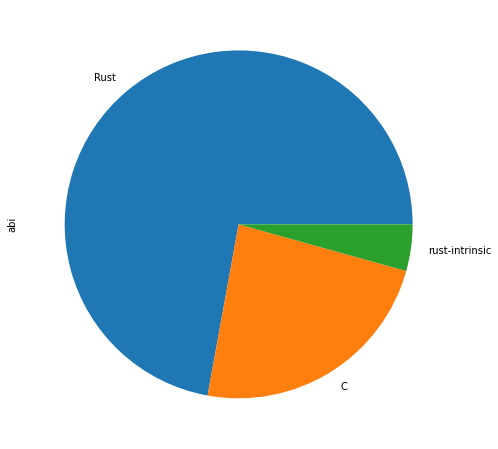

In [19]:
# Frequency of abi CALLS
unsafe_const_calls = const_calls[
    const_calls.unsafety == "Unsafe"
]
unsafe_const_calls_250 = unsafe_const_calls[
    unsafe_const_calls.crate_callsite.isin(sorted_crates[:250])
]
values_250 = unsafe_const_calls_250.abi.value_counts()

print("------top 250------")
print(values_250)
print()
print("Percents: ")
print(values_250 / len(unsafe_const_calls_250) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls_250))
values_250.plot.pie()

del values_250

------top 500------
Rust              7739
C                 2213
rust-intrinsic     544
Name: abi, dtype: int64

Percents: 
Rust              73.732851
C                 21.084223
rust-intrinsic     5.182927
Name: abi, dtype: float64

Unsafe calls: 10496


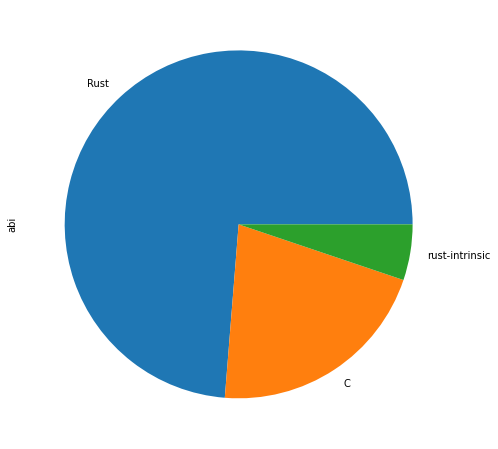

In [20]:
unsafe_const_calls_500 = unsafe_const_calls[
    unsafe_const_calls.crate_callsite.isin(sorted_crates[:500])
]
values_500 = unsafe_const_calls_500.abi.value_counts()

print("------top 500------")
print(values_500)
print()
print("Percents: ")
print(values_500 / len(unsafe_const_calls_500) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls_500))
values_500.plot.pie()

del values_500

------top 1000------
Rust              7767
C                 2231
rust-intrinsic     638
Name: abi, dtype: int64

Percents: 
Rust              73.025574
C                 20.975931
rust-intrinsic     5.998496
Name: abi, dtype: float64

Unsafe calls: 10636


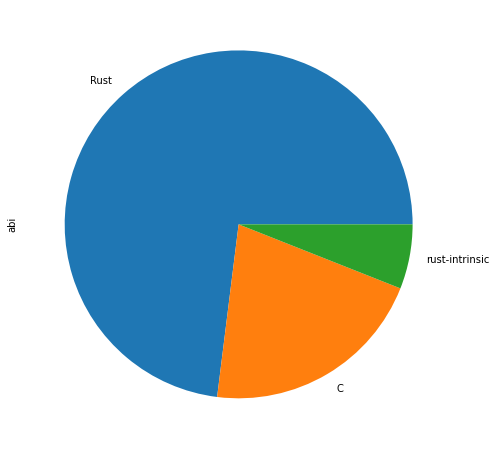

In [21]:
unsafe_const_calls_1000 = unsafe_const_calls[
    unsafe_const_calls.crate_callsite.isin(sorted_crates[:1000])
]
values_1000 = unsafe_const_calls_1000.abi.value_counts()

print("------top 1000------")
print(values_1000)
print()
print("Percents: ")
print(values_1000 / len(unsafe_const_calls_1000) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls_1000))
values_1000.plot.pie()

del values_1000

------total------
Rust              7844
C                 2242
rust-intrinsic     644
Name: abi, dtype: int64

Percents: 
Rust              73.103448
C                 20.894688
rust-intrinsic     6.001864
Name: abi, dtype: float64

Unsafe calls: 10730


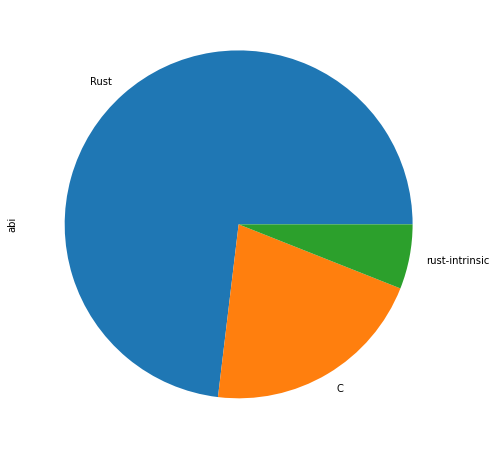

In [22]:
# Frequency of abi CALLS
values = unsafe_const_calls.abi.value_counts()

print("------total------")
print(values)
print()
print("Percents: ")
print(values / len(unsafe_const_calls) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls))
values.plot.pie()

del values

In [23]:
# Which crates call unsafe Rust functions? - ALL
calls_unsafe_rust_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "Rust"
]
#values = calls_unsafe_rust_funcs[['crate_callsite', 'package_version']].apply(
#    lambda row: (row['crate_callsite'], row['package_version']), axis=1
#).squeeze().value_counts()

# Filter by user-written blocks
uw_calls_unsafe_rust_funcs = calls_unsafe_rust_funcs[
    calls_unsafe_rust_funcs.check_mode == "UnsafeBlockUserProvided"
]
values_uw = uw_calls_unsafe_rust_funcs[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()

#print(len(values))
#print(len(values_uw))
#print()
#assert(len(values) == len(values_uw))
#del values

print("------top 250------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(sorted_crates[:250])
]
values = uw_urust[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------top 500------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(sorted_crates[:500])
]
values = uw_urust[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------top 1000------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(sorted_crates[:1000])
]
values = uw_urust[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------total------")
print("Number of crates that call unsafe Rust:\t", len(values_uw))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values_uw[:20])
del values_uw

------top 250------
Number of crates that call unsafe Rust:	 114
Top 20 crates with most unsafe Rust calls:	

(futures_util, 0.3.6)       483
(ppv_lite86, 0.2.9)         365
(openssl, 0.10.30)          342
(tokio, 0.2.22)             329
(encoding_rs, 0.8.24)       233
(generic_array, 0.14.4)     188
(nix, 0.19.0)               181
(itoa, 0.4.6)               171
(hashbrown, 0.9.1)          159
(rayon, 1.4.1)              119
(core_foundation, 0.9.1)    112
(smallvec, 1.4.2)            91
(hyper, 0.13.8)              79
(crossbeam_deque, 0.8.0)     79
(byteorder, 1.3.4)           72
(socket2, 0.3.15)            71
(bstr, 0.2.13)               68
(lock_api, 0.4.1)            66
(crossbeam_epoch, 0.9.0)     60
(arrayvec, 0.5.1)            55
dtype: int64

------top 500------
Number of crates that call unsafe Rust:	 187
Top 20 crates with most unsafe Rust calls:	

(js_sys, 0.3.45)            1270
(futures_util, 0.3.6)        483
(git2, 0.13.12)              381
(ppv_lite86, 0.2.9)        

In [24]:
# Which crates call C functions?
calls_c_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "C"
]

print("------top 250------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(sorted_crates[:250])
]
values = calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
print()
del values

print("------top 500------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(sorted_crates[:500])
]
values = calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
print()
del values

print("------top 1000------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(sorted_crates[:1000])
]
values = calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
print()
del values

print("------total------")
values = calls_c_funcs[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
del values

------top 250------
Number of crates that call C functions:	 21
Top 20 crates with most C calls:

(openssl, 0.10.30)               747
(nix, 0.19.0)                    351
(core_foundation, 0.9.1)         161
(ring, 0.17.0-alpha.4)            55
(socket2, 0.3.15)                 24
(mio_uds, 0.6.8)                  17
(net2, 0.2.35)                    13
(signal_hook_registry, 1.2.1)      8
(getrandom, 0.2.0)                 5
(backtrace, 0.3.53)                5
(filetime, 0.2.12)                 5
(chrono, 0.4.19)                   3
(tempfile, 3.1.0)                  3
(num_cpus, 1.13.0)                 3
(time, 0.2.22)                     2
(parking_lot_core, 0.8.0)          2
(tokio_uds, 0.2.7)                 1
(openssl_sys, 0.9.58)              1
(atty, 0.2.14)                     1
(which, 4.0.2)                     1
dtype: int64

------top 500------
Number of crates that call C functions:	 48
Top 20 crates with most C calls:

(openssl, 0.10.30)               747
(git2, 0.13.1

In [25]:
# Not included in <top 1000> b/c under "rust_crypto" in sorted_crates list ^^^; are we OK w this???
#calls_c_funcs_ = calls_c_funcs[
#    calls_c_funcs.crate_defsite.eq("crypto")
#]
#calls_c_funcs_

In [26]:
# SIMD const calls
simd_functions = set([
    x
    for x in const_calls.def_path.unique()
    if x.startswith('core[' + core_hash + ']::core_arch')
])
simd_calls = const_calls[
    const_calls.def_path.isin(simd_functions)
]

print("------top 250------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(sorted_crates[:250])
]
simd_crates = top_simd[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------top 500------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(sorted_crates[:500])
]
simd_crates = top_simd[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------top 1000------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(sorted_crates[:1000])
]
simd_crates = top_simd[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------total------")
simd_crates = simd_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of SIMD calls:\t\t\t", len(simd_calls))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
del simd_crates

------top 250------
Number of SIMD calls:			 386
Number of crates that call SIMD:	 4
Crates that call SIMD functions:
(ppv_lite86, 0.2.9)    360
(bstr, 0.2.13)          16
(hashbrown, 0.9.1)       8
(sha2, 0.9.1)            2
dtype: int64

------top 500------
Number of SIMD calls:			 391
Number of crates that call SIMD:	 7
Crates that call SIMD functions:
(ppv_lite86, 0.2.9)    360
(bstr, 0.2.13)          16
(hashbrown, 0.9.1)       8
(rdrand, 0.7.0)          2
(sha1, 0.9.1)            2
(sha2, 0.9.1)            2
(ahash, 0.4.6)           1
dtype: int64

------top 1000------
Number of SIMD calls:			 391
Number of crates that call SIMD:	 7
Crates that call SIMD functions:
(ppv_lite86, 0.2.9)    360
(bstr, 0.2.13)          16
(hashbrown, 0.9.1)       8
(rdrand, 0.7.0)          2
(sha1, 0.9.1)            2
(sha2, 0.9.1)            2
(ahash, 0.4.6)           1
dtype: int64

------total------
Number of SIMD calls:			 391
Number of crates that call SIMD:	 7
Crates that call SIMD functions:
(

In [27]:
# Count functions with assembly code, per crate
asm_fns = function_unsafe_reasons[function_unsafe_reasons["use of inline assembly"]]
print("Number of functions using inline assembly:\t", len(asm_fns))
if len(asm_fns) > 0:
    values = asm_fns[['crate_name', 'crate_hash']].apply(
        lambda row: (row['crate_name'], row['crate_hash']), axis=1
    ).squeeze().value_counts()
    print("Number of crates:", len(values))
    print()
    print('Percentage of functions with inline assembly among 10 top crates:', sum(values[:10])/len(asm_fns)*100)
    print("Such functions per crate:")
    print(values[:10])
    asm_fns
    del values

Number of functions using inline assembly:	 0


In [28]:
# Unchecked functions
const_unchecked_calls = const_calls[
    const_calls.def_path.isin(unchecked_function_names)
]
unchecked_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unchecked_function_names)
]
assert(len(const_unchecked_calls) == len(unchecked_calls))
del const_unchecked_calls

print("------top 250------")
def filter_func(x):
    if x.split("[")[0] in sorted_crates[:250]:
        return True
    else:
        return False

names = filter(filter_func, unchecked_function_names)
count = 0
for n in names:
    count+=1

top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(sorted_crates[:250])
]
values = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("unchecked_function_names:\t", count)
print("Calls to unchecked functions:\t", len(top_unchecked))
print("Percentage:\t\t\t", len(top_unchecked)/len(unsafe_calls)*100)
print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(top_250_builds)*100)
print(values[:5])
print()
del values, names, count, top_unchecked, filter_func

print("------top 500------")
def filter_func(x):
    if x.split("[")[0] in sorted_crates[:500]:
        return True
    else:
        return False

names = filter(filter_func, unchecked_function_names)
count = 0
for n in names:
    count+=1

top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(sorted_crates[:500])
]
values = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("unchecked_function_names:\t", count)
print("Calls to unchecked functions:\t", len(top_unchecked))
print("Percentage:\t\t\t", len(top_unchecked)/len(unsafe_calls)*100)
print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(top_500_builds)*100)
print(values[:5])
print()
del values, names, count, top_unchecked, filter_func

print("------top 1000------")
def filter_func(x):
    if x.split("[")[0] in sorted_crates[:1000]:
        return True
    else:
        return False

names = filter(filter_func, unchecked_function_names)
count = 0
for n in names:
    count+=1

top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(sorted_crates[:1000])
]
values = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("unchecked_function_names:\t", count)
print("Calls to unchecked functions:\t", len(top_unchecked))
print("Percentage:\t\t\t", len(top_unchecked)/len(unsafe_calls)*100)
print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(top_1000_builds)*100)
print(values[:5])
print()
del values, names, count, top_unchecked, filter_func

print("------total------")
values = unchecked_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("unchecked_function_names:\t", len(unchecked_function_names))
print("Calls to unchecked functions:\t", len(unchecked_calls))
print("Percentage:\t\t\t", len(unchecked_calls)/len(unsafe_calls)*100)
print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
print(values[:5])
del values

------top 250------
unchecked_function_names:	 127
Calls to unchecked functions:	 37
Percentage:			 0.03850436556252797

Number of crates:		 12
Percentage:			 4.838709677419355
(http, 0.2.1)         14
(arrayvec, 0.5.1)      6
(h2, 0.2.6)            4
(try_lock, 0.2.3)      3
(once_cell, 1.4.1)     2
dtype: int64

------top 500------
unchecked_function_names:	 366
Calls to unchecked functions:	 93
Percentage:			 0.0967812431706784

Number of crates:		 23
Percentage:			 4.791666666666667
(json, 0.12.4)        14
(http, 0.2.1)         14
(pest, 2.1.3)          8
(criterion, 0.3.3)     7
(bytecount, 0.6.0)     6
dtype: int64

------top 1000------
unchecked_function_names:	 366
Calls to unchecked functions:	 93
Percentage:			 0.0967812431706784

Number of crates:		 23
Percentage:			 4.713114754098361
(json, 0.12.4)        14
(http, 0.2.1)         14
(pest, 2.1.3)          8
(criterion, 0.3.3)     7
(bytecount, 0.6.0)     6
dtype: int64

------total------
unchecked_function_names:	 366
Call

In [29]:
# Unguarded functions
print("unguarded_function_names:\t", len(unguarded_function_names))
print(unguarded_function_names)

const_unguarded_calls = const_calls[
    const_calls.def_path.isin(unguarded_function_names)
]
unguarded_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unguarded_function_names)
]
assert(len(const_unguarded_calls) == len(unguarded_calls))

print("Calls to unguarded functions:\t", len(unguarded_calls))
print("Percentage:\t\t\t", len(unguarded_calls)/len(unsafe_calls)*100)

#values = unguarded_calls[['crate_callsite', 'build_crate_hash']].apply(
#    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
#).squeeze().value_counts()
#print("Number of crates:\t\t", len(values))
#print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
#print(values[:5])

#print("Percentage of unsafe blocks with an unguarded function call:\t",
#     len(unguarded_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
#)
#del values

unguarded_function_names:	 0
set()
Calls to unguarded functions:	 0
Percentage:			 0.0


In [30]:
# Filter by target language
user_written_unsafe_const_calls_rust = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "Rust"
]
user_written_unsafe_const_calls_fi = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "C"
]

In [31]:
# Filter for get_unchecked calls
unchecked = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[' + core_hash + ']::slice[0]::{{impl}}[0]::get_unchecked[0]')
        or x.startswith('core[' + core_hash + ']::slice[0]::{{impl}}[0]::get_unchecked_mut[0]')
])

unchecked_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(unchecked)
]

print("------top 250------")
top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(sorted_crates[:250])
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v)
print()
del cleaned_unchecked_calls, top_unchecked

print("------top 500------")
top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(sorted_crates[:500])
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v)
print()
del cleaned_unchecked_calls, top_unchecked

print("------top 1000------")
top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(sorted_crates[:1000])
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v)
print()
del cleaned_unchecked_calls, top_unchecked

print("------total------")
cleaned_unchecked_calls = unchecked_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v) # crypto again
del cleaned_unchecked_calls

------top 250------
Number of crates that use get_unchecked[_mut]:	 14

('encoding_rs', '0.8.24') 113
('rayon', '1.4.1') 30
('rand_hc', '0.2.0') 16
('fixedbitset', '0.3.1') 10
('crossbeam_deque', '0.8.0') 10
('httparse', '1.3.4') 9
('siphasher', '0.3.3') 4
('ryu', '1.0.5') 4
('petgraph', '0.5.1') 3
('crossbeam_queue', '0.3.0') 3
('bstr', '0.2.13') 3
('generic_array', '0.14.4') 2
('rand_core', '0.5.1') 2
('crossbeam_channel', '0.5.0') 1

------top 500------
Number of crates that use get_unchecked[_mut]:	 24

('lexical_core', '0.7.4') 245
('encoding_rs', '0.8.24') 113
('priority_queue', '1.0.2') 54
('rayon', '1.4.1') 30
('combine', '4.3.2') 16
('rand_hc', '0.2.0') 16
('json', '0.12.4') 12
('crossbeam_deque', '0.8.0') 10
('fixedbitset', '0.3.1') 10
('httparse', '1.3.4') 9
('ryu', '1.0.5') 4
('siphasher', '0.3.3') 4
('petgraph', '0.5.1') 3
('crossbeam_queue', '0.3.0') 3
('bstr', '0.2.13') 3
('rand_core', '0.5.1') 2
('generic_array', '0.14.4') 2
('futf', '0.1.4') 2
('criterion', '0.3.3') 2


In [32]:
# Filter for perf-mot functions within Rust
perf_mot_unsafe_rust = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[' + core_hash + ']::core_arch') 
        or x.startswith('core[' + core_hash + ']::intrinsics[0]::[1]::transmute[0]')
        or x.startswith('core[' + core_hash + ']::intrinsics[0]::write_bytes[0]')
        or x.startswith('core[' + core_hash + ']::intrinsics[0]::copy[0]')
        or x.startswith('core[' + core_hash + ']::intrinsics[0]::copy_nonoverlapping[0]')
        or x.startswith('core[' + core_hash + ']::mem[0]::transmute_copy[0]')
        or x.startswith('core[' + core_hash + ']::slice[0]::from_raw_parts[0]')
        or x.startswith('core[' + core_hash + ']::slice[0]::from_raw_parts_mut[0]')
        or x.startswith('core[' + core_hash + ']::slice[0]::{{impl}}[0]::as_ptr[0]')
        or x.startswith('core[' + core_hash + ']::slice[0]::{{impl}}[0]::as_mut_ptr[0]')
        or ("unchecked" in x)
        or ("unguarded" in x)
        #or ("asm!" in x) # FIXME
])

# Performance-motivated Rust calls
perf_mot_unsafe_rust_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(perf_mot_unsafe_rust)
]

In [33]:
# PMU CALLS

print("------top 250------")

top_uw_unsafe_const_calls = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.crate_callsite.isin(sorted_crates[:250])
]
top_pmu_rust_calls = perf_mot_unsafe_rust_calls[
    perf_mot_unsafe_rust_calls.crate_callsite.isin(sorted_crates[:250])
]
top_fi_calls = user_written_unsafe_const_calls_fi[
    user_written_unsafe_const_calls_fi.crate_callsite.isin(sorted_crates[:250])
]
top_c_calls = user_written_unsafe_const_calls_c[
    user_written_unsafe_const_calls_c.crate_callsite.isin(sorted_crates[:250])
]

pmu_rust_calls = top_pmu_rust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
fi_calls = top_fi_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
c_calls = top_c_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)

len_all = len(top_pmu_rust_calls) + len(top_fi_calls) + len(top_c_calls)
block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()

print("Total number of (user-written) PMU Rust calls:\t", len(top_pmu_rust_calls))
print("Percent out of unsafe const calls:\t\t", len(top_pmu_rust_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(top_250_builds)*100)
print()
print("Total number of ForeignItem calls:\t", len(top_fi_calls))
print("Percent out of unsafe const calls:\t", len(top_fi_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(top_250_builds)*100)
print()
print("Total number of C calls:\t\t", len(top_c_calls))
print("Percent out of unsafe const calls:\t", len(top_c_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(top_250_builds)*100)
print()
print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(top_uw_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(top_uw_unsafe_const_calls)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_250_builds)*100)

del len_all, block_frames, block_values
del top_uw_unsafe_const_calls, top_pmu_rust_calls, top_fi_calls, top_c_calls

# PMU DEFINITIONS (excluding Rust b/c would have to do more in depth analysis of function bodies)

print()
print()
print("------top 250 non-Rust PMU defs------")
print()

top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(sorted_crates[:250])
]
def_c = def_c_funcs[
    def_c_funcs.crate.isin(sorted_crates[:250])
]
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(sorted_crates[:250])
]

len_all = len(def_c) + len(def_fi)
block_frames = [def_c, def_fi]
block_values = pd.concat(block_frames).crate.value_counts()

print("Total number of ForeignItem definitions:", len(def_fi))
print("Percent out of unsafe definitions:\t", len(def_fi)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_fi.crate.value_counts()))
print("Percentage:\t\t", len(def_fi.crate.value_counts())/len(top_250_builds)*100)
print()
print("Total number of C definitions:\t\t", len(def_c))
print("Percent out of unsafe definitions:\t", len(def_c)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_c.crate.value_counts()))
print("Percentage:\t\t", len(def_c.crate.value_counts())/len(top_250_builds)*100)
print()
print("Total number of non-Rust PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(top_unsafe_defs))
print("Percent non-Rust PMU out of unsafe definitions:\t", len_all/len(top_unsafe_defs)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_250_builds)*100)

del len_all, block_frames, block_values, top_unsafe_defs

# Total PMU code

print()
print()
print("------top 250 PMU------")
print()

block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c, def_fi] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_250_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values, pmu_rust_calls, fi_calls, c_calls, def_c, def_fi

------top 250------
Total number of (user-written) PMU Rust calls:	 2446
Percent out of unsafe const calls:		 18.03435818034358
Number of crates:	 77
Percentage:		 31.048387096774192

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 1419
Percent out of unsafe const calls:	 10.46228710462287
Number of crates:	 21
Percentage:		 8.46774193548387

Total number of (user-written) PMU calls:		 3865
Out of total number user-written unsafe const calls:	 13563
Percent user-written PMU out of const calls:		 28.496645284966455

Number of crates:	 86
Percentage:		 34.67741935483871


------top 250 non-Rust PMU defs------

Total number of ForeignItem definitions: 1897
Percent out of unsafe definitions:	 59.00466562986003
Number of crates:	 10
Percentage:		 4.032258064516129

Total number of C definitions:		 47
Percent out of unsafe definitions:	 1.4618973561430793
Number of crates:	 4
Percentage:		 1.6129

In [34]:
# PMU CALLS

print()
print("------top 500------")
print()

top_uw_unsafe_const_calls = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.crate_callsite.isin(sorted_crates[:500])
]
top_pmu_rust_calls = perf_mot_unsafe_rust_calls[
    perf_mot_unsafe_rust_calls.crate_callsite.isin(sorted_crates[:500])
]
top_fi_calls = user_written_unsafe_const_calls_fi[
    user_written_unsafe_const_calls_fi.crate_callsite.isin(sorted_crates[:500])
]
top_c_calls = user_written_unsafe_const_calls_c[
    user_written_unsafe_const_calls_c.crate_callsite.isin(sorted_crates[:500])
]

pmu_rust_calls = top_pmu_rust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
fi_calls = top_fi_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
c_calls = top_c_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)

len_all = len(top_pmu_rust_calls) + len(top_fi_calls) + len(top_c_calls)
block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()

print("Total number of (user-written) PMU Rust calls:\t", len(top_pmu_rust_calls))
print("Percent out of unsafe const calls:\t\t", len(top_pmu_rust_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(top_500_builds)*100)
print()
print("Total number of ForeignItem calls:\t", len(top_fi_calls))
print("Percent out of unsafe const calls:\t", len(top_fi_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(top_500_builds)*100)
print()
print("Total number of C calls:\t\t", len(top_c_calls))
print("Percent out of unsafe const calls:\t", len(top_c_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(top_500_builds)*100)
print()
print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(top_uw_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(top_uw_unsafe_const_calls)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_500_builds)*100)

del len_all, block_frames, block_values
del top_uw_unsafe_const_calls, top_pmu_rust_calls, top_fi_calls, top_c_calls

# PMU DEFINITIONS (excluding Rust b/c would have to do more in depth analysis of function bodies)

print()
print()
print("------top 500 non-Rust PMU defs------")
print()

top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(sorted_crates[:500])
]
def_c = def_c_funcs[
    def_c_funcs.crate.isin(sorted_crates[:500])
]
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(sorted_crates[:500])
]

len_all = len(def_c) + len(def_fi)
block_frames = [def_c, def_fi]
block_values = pd.concat(block_frames).crate.value_counts()

print("Total number of ForeignItem definitions:", len(def_fi))
print("Percent out of unsafe definitions:\t", len(def_fi)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_fi.crate.value_counts()))
print("Percentage:\t\t", len(def_fi.crate.value_counts())/len(top_500_builds)*100)
print()
print("Total number of C definitions:\t\t", len(def_c))
print("Percent out of unsafe definitions:\t", len(def_c)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_c.crate.value_counts()))
print("Percentage:\t\t", len(def_c.crate.value_counts())/len(top_500_builds)*100)
print()
print("Total number of non-Rust PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(top_unsafe_defs))
print("Percent non-Rust PMU out of unsafe definitions:\t", len_all/len(top_unsafe_defs)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_500_builds)*100)

del len_all, block_frames, block_values, top_unsafe_defs

# Total PMU code

print()
print()
print("------top 500 PMU------")
print()

block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c, def_fi] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_500_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])

del block_frames, block_values, pmu_rust_calls, fi_calls, c_calls, def_c, def_fi


------top 500------

Total number of (user-written) PMU Rust calls:	 3315
Percent out of unsafe const calls:		 14.175147524159753
Number of crates:	 128
Percentage:		 26.666666666666668

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 2223
Percent out of unsafe const calls:	 9.50568716326007
Number of crates:	 48
Percentage:		 10.0

Total number of (user-written) PMU calls:		 5538
Out of total number user-written unsafe const calls:	 23386
Percent user-written PMU out of const calls:		 23.680834687419825

Number of crates:	 150
Percentage:		 31.25


------top 500 non-Rust PMU defs------

Total number of ForeignItem definitions: 3469
Percent out of unsafe definitions:	 54.690209679962166
Number of crates:	 30
Percentage:		 6.25

Total number of C definitions:		 176
Percent out of unsafe definitions:	 2.7747122812549265
Number of crates:	 7
Percentage:		 1.4583333333333333

Total number of n

In [35]:
# PMU CALLS

print()
print("------top 1000 PMU calls------")
print()

top_uw_unsafe_const_calls = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.crate_callsite.isin(sorted_crates[:1000])
]
top_pmu_rust_calls = perf_mot_unsafe_rust_calls[
    perf_mot_unsafe_rust_calls.crate_callsite.isin(sorted_crates[:1000])
]
top_fi_calls = user_written_unsafe_const_calls_fi[
    user_written_unsafe_const_calls_fi.crate_callsite.isin(sorted_crates[:1000])
]
top_c_calls = user_written_unsafe_const_calls_c[
    user_written_unsafe_const_calls_c.crate_callsite.isin(sorted_crates[:1000])
]

pmu_rust_calls = top_pmu_rust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
fi_calls = top_fi_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
c_calls = top_c_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)

len_all = len(top_pmu_rust_calls) + len(top_fi_calls) + len(top_c_calls)
block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()

print("Total number of (user-written) PMU Rust calls:\t", len(top_pmu_rust_calls))
print("Percent out of unsafe const calls:\t\t", len(top_pmu_rust_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of ForeignItem calls:\t", len(top_fi_calls))
print("Percent out of unsafe const calls:\t", len(top_fi_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of C calls:\t\t", len(top_c_calls))
print("Percent out of unsafe const calls:\t", len(top_c_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(top_uw_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(top_uw_unsafe_const_calls)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_1000_builds)*100)

del len_all, block_frames, block_values
del top_uw_unsafe_const_calls, top_pmu_rust_calls, top_fi_calls, top_c_calls

# PMU DEFINITIONS (excluding Rust b/c would have to do more in depth analysis of function bodies)

print()
print()
print("------top 1000 non-Rust PMU defs------")
print()

top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(sorted_crates[:1000])
]
def_c = def_c_funcs[
    def_c_funcs.crate.isin(sorted_crates[:1000])
]
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(sorted_crates[:1000])
]

len_all = len(def_c) + len(def_fi)
block_frames = [def_c, def_fi]
block_values = pd.concat(block_frames).crate.value_counts()

print("Total number of ForeignItem definitions:", len(def_fi))
print("Percent out of unsafe definitions:\t", len(def_fi)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_fi.crate.value_counts()))
print("Percentage:\t\t", len(def_fi.crate.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of C definitions:\t\t", len(def_c))
print("Percent out of unsafe definitions:\t", len(def_c)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_c.crate.value_counts()))
print("Percentage:\t\t", len(def_c.crate.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of non-Rust PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(top_unsafe_defs))
print("Percent non-Rust PMU out of unsafe definitions:\t", len_all/len(top_unsafe_defs)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_1000_builds)*100)

del len_all, block_frames, block_values, top_unsafe_defs

# Total PMU code

print()
print()
print("------top 1000 PMU------")
print()

block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c, def_fi] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_1000_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values, pmu_rust_calls, fi_calls, c_calls, def_c, def_fi


------top 1000 PMU calls------

Total number of (user-written) PMU Rust calls:	 3326
Percent out of unsafe const calls:		 14.102183591265636
Number of crates:	 131
Percentage:		 26.84426229508197

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 2241
Percent out of unsafe const calls:	 9.501801992792029
Number of crates:	 50
Percentage:		 10.245901639344263

Total number of (user-written) PMU calls:		 5567
Out of total number user-written unsafe const calls:	 23585
Percent user-written PMU out of const calls:		 23.603985584057664

Number of crates:	 153
Percentage:		 31.352459016393443


------top 1000 non-Rust PMU defs------

Total number of ForeignItem definitions: 3469
Percent out of unsafe definitions:	 54.68158890290038
Number of crates:	 30
Percentage:		 6.147540983606557

Total number of C definitions:		 176
Percent out of unsafe definitions:	 2.7742749054224465
Number of crates:	 7


In [36]:
# PMU CALLS

print("------total PMU calls------")
print()

pmu_rust_calls = perf_mot_unsafe_rust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
fi_calls = user_written_unsafe_const_calls_fi[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
c_calls = user_written_unsafe_const_calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)

len_all = len(perf_mot_unsafe_rust_calls) + len(user_written_unsafe_const_calls_fi) + len(user_written_unsafe_const_calls_c)
block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()

print("Total number of (user-written) PMU Rust calls:\t", len(perf_mot_unsafe_rust_calls))
print("Percent out of unsafe const calls:\t\t", len(perf_mot_unsafe_rust_calls)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(selected_builds)*100)
print()
print("Total number of ForeignItem calls:\t", len(user_written_unsafe_const_calls_fi))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_fi)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(selected_builds)*100)
print()
print("Total number of C calls:\t\t", len(user_written_unsafe_const_calls_c))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_c)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(selected_builds)*100)
print()
print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(user_written_unsafe_const_calls)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)

del len_all, block_frames, block_values

# PMU DEFINITIONS (excluding Rust b/c would have to do more in depth analysis of function bodies)

print()
print()
print("------total non-Rust PMU defs------")
print()

len_all = len(def_c_funcs) + len(def_fi_funcs)
block_frames = [def_c_funcs, def_fi_funcs]
block_values = pd.concat(block_frames).crate.value_counts()

print("Total number of ForeignItem definitions:", len(def_fi_funcs))
print("Percent out of unsafe definitions:\t", len(def_fi_funcs)/len(unsafe_function_definitions)*100)
print("Number of crates:\t", len(def_fi_funcs.crate.value_counts()))
print("Percentage:\t\t", len(def_fi_funcs.crate.value_counts())/len(selected_builds)*100)
print()
print("Total number of C definitions:\t\t", len(def_c_funcs))
print("Percent out of unsafe definitions:\t", len(def_c_funcs)/len(unsafe_function_definitions)*100)
print("Number of crates:\t", len(def_c_funcs.crate.value_counts()))
print("Percentage:\t\t", len(def_c_funcs.crate.value_counts())/len(selected_builds)*100)
print()
print("Total number of non-Rust PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(unsafe_function_definitions))
print("Percent non-Rust PMU out of unsafe definitions:\t", len_all/len(unsafe_function_definitions)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
del len_all, block_frames, block_values

# Total PMU code

print()
print()
print("------total PMU------")
print()

block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c_funcs, def_fi_funcs] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values

------total PMU calls------

Total number of (user-written) PMU Rust calls:	 3394
Percent out of unsafe const calls:		 14.300160107862139
Number of crates:	 133
Percentage:		 26.078431372549023

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 2252
Percent out of unsafe const calls:	 9.488497514114771
Number of crates:	 51
Percentage:		 10.0

Total number of (user-written) PMU calls:		 5646
Out of total number user-written unsafe const calls:	 23734
Percent user-written PMU out of const calls:		 23.78865762197691

Number of crates:	 155
Percentage:		 30.392156862745097


------total non-Rust PMU defs------

Total number of ForeignItem definitions: 3478
Percent out of unsafe definitions:	 54.74578939083897
Number of crates:	 31
Percentage:		 6.078431372549019

Total number of C definitions:		 176
Percent out of unsafe definitions:	 2.7703447190303794
Number of crates:	 7
Percentage:		 1.37254